In [1]:
%cd /home/hotson/kaggle_work/csiro-biomass/

/home/hotson/kaggle_work/csiro-biomass


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv("train.csv")
train_df['sample_id'] = train_df['sample_id'].apply(lambda x: x.split("_")[0])
train_df = train_df.groupby(by = "sample_id").agg(list).reset_index()

info_cols = ["image_path", "Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"]
for col in info_cols: train_df[col] = train_df[col].apply(lambda x: x[0])


target_values = train_df.apply(
    lambda row: pd.Series(dict(zip(row["target_name"], row["target"]))), axis=1
)

train_df = pd.concat([train_df.drop(columns=["target_name", "target"]), target_values], axis=1)

train_df

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...,...,...,...,...,...,...
352,ID975115267,train/ID975115267.jpg,2015/7/8,WA,Clover,0.73,3.0000,40.0300,0.0000,0.8000,40.8300,40.8300
353,ID978026131,train/ID978026131.jpg,2015/9/4,Tas,Clover,0.83,3.1667,24.6445,4.1948,12.0601,40.8994,36.7046
354,ID980538882,train/ID980538882.jpg,2015/2/24,NSW,Phalaris,0.69,29.0000,0.0000,1.1457,91.6543,92.8000,91.6543
355,ID980878870,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,32.3575,0.0000,2.0325,34.3900,34.3900


## Null check

In [4]:
train_df.isnull().sum()

sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64

## Validation

In [5]:
gdm_match = np.isclose(
    train_df["Dry_Green_g"] + train_df["Dry_Clover_g"],
    train_df["GDM_g"]
)

total_match_1 = np.isclose(
    train_df["Dry_Green_g"] + train_df["Dry_Clover_g"] + train_df["Dry_Dead_g"],
    train_df["Dry_Total_g"]
)

total_match_2 = np.isclose(
    train_df["GDM_g"] + train_df["Dry_Dead_g"],
    train_df["Dry_Total_g"]
)

# Create summary DataFrame
results_df = pd.DataFrame({
    "Validation": ["GDM_g = Green + Clover", 
                   "Total = Green + Clover + Dead", 
                   "Total = GDM + Dead"],
    "Matches": [gdm_match.sum(), total_match_1.sum(), total_match_2.sum()],
    "Mismatches": [len(train_df) - gdm_match.sum(),
                   len(train_df) - total_match_1.sum(),
                   len(train_df) - total_match_2.sum()],
    "Match %": [gdm_match.mean() * 100,
                total_match_1.mean() * 100,
                total_match_2.mean() * 100]
})

print(results_df)


                      Validation  Matches  Mismatches    Match %
0         GDM_g = Green + Clover      356           1  99.719888
1  Total = Green + Clover + Dead      356           1  99.719888
2             Total = GDM + Dead      356           1  99.719888


## Correlation plot

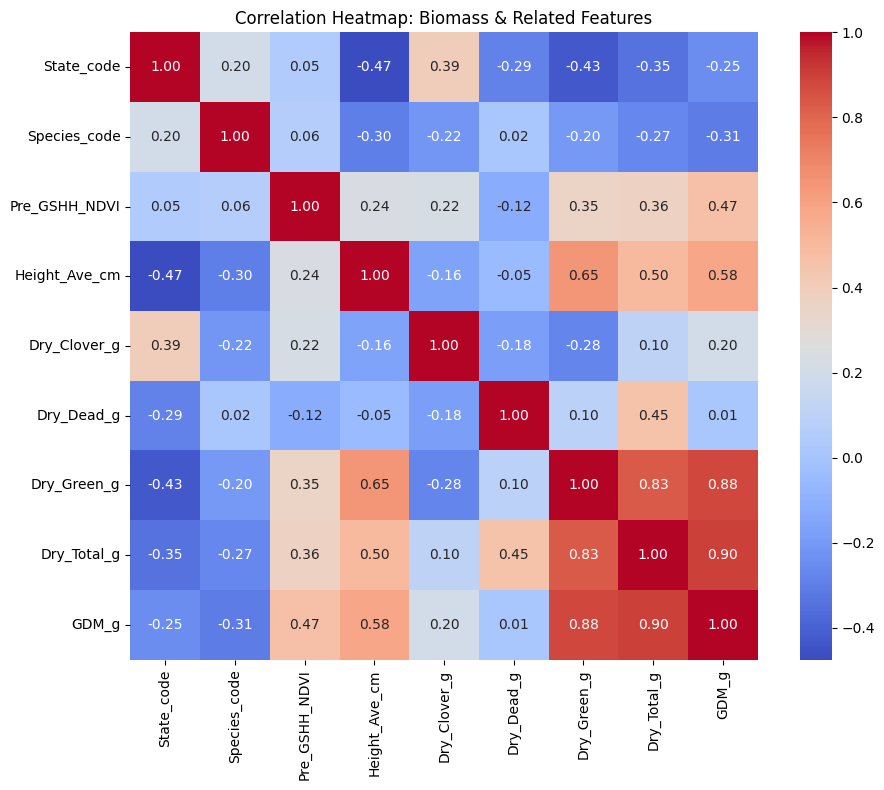

In [6]:
# Encode categorical variables
train_df["State_code"] = train_df["State"].astype("category").cat.codes
train_df["Species_code"] = train_df["Species"].astype("category").cat.codes

# Correlation plot
corr_df = train_df[[
    "State_code", "Species_code", "Pre_GSHH_NDVI", "Height_Ave_cm",
    "Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"
]]

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: Biomass & Related Features")
plt.tight_layout()
plt.show()

## Distribution

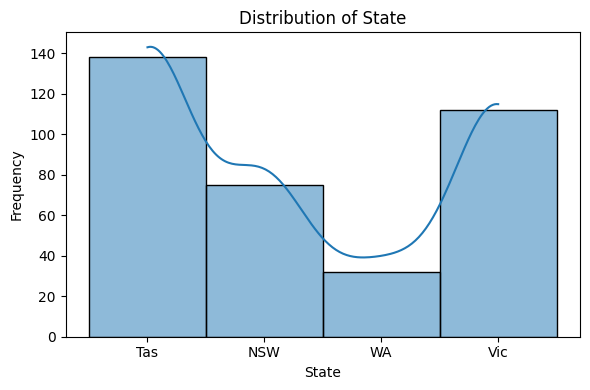

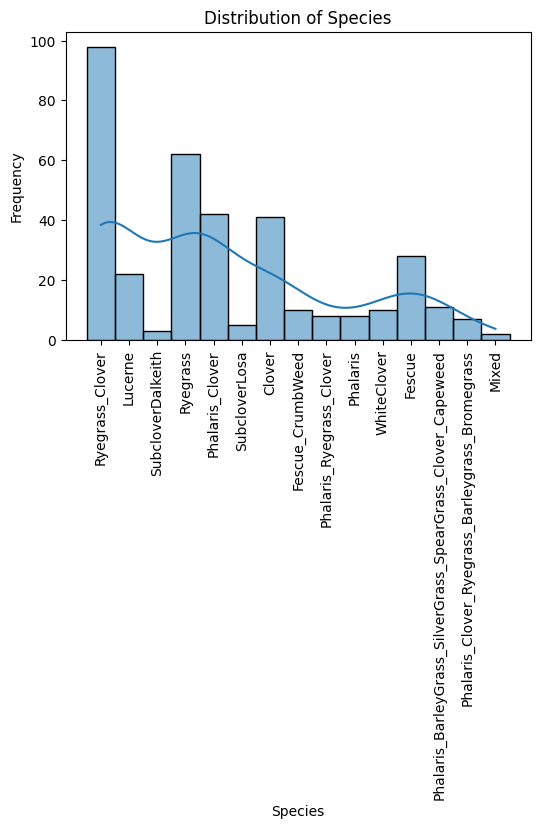

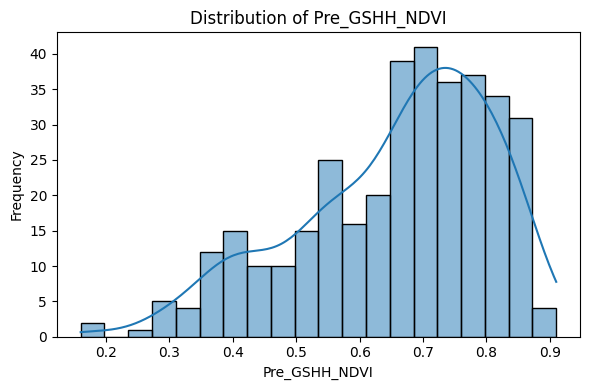

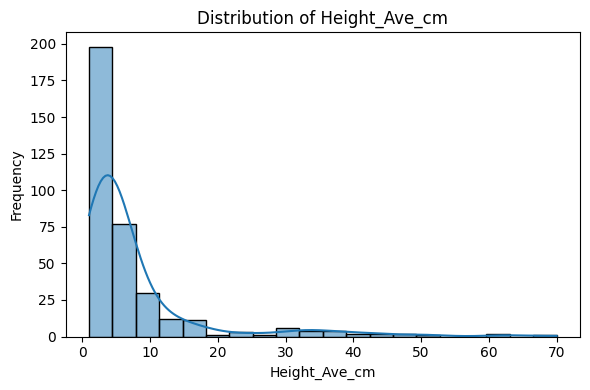

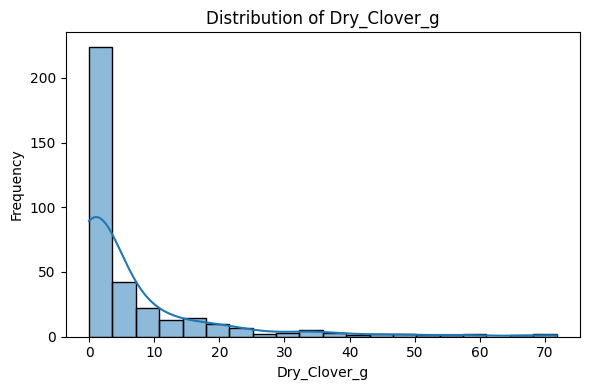

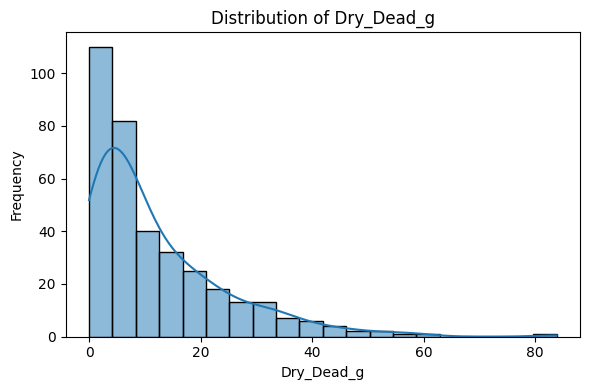

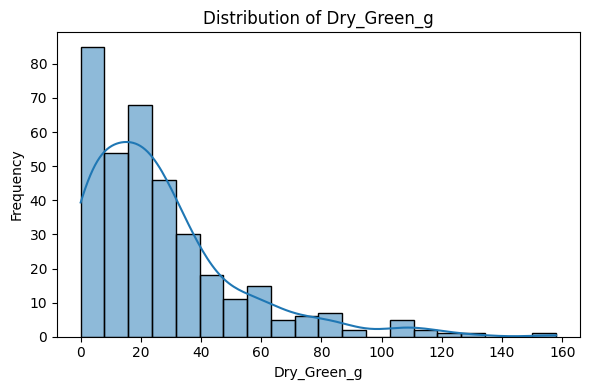

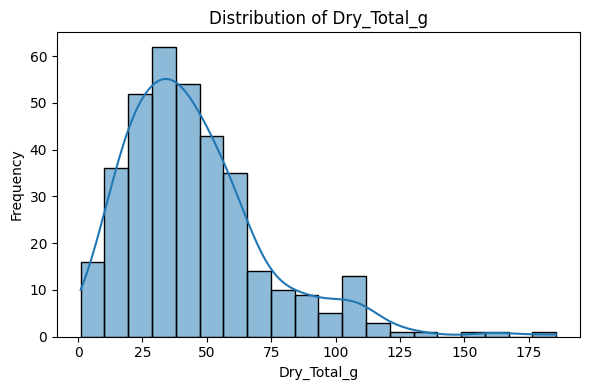

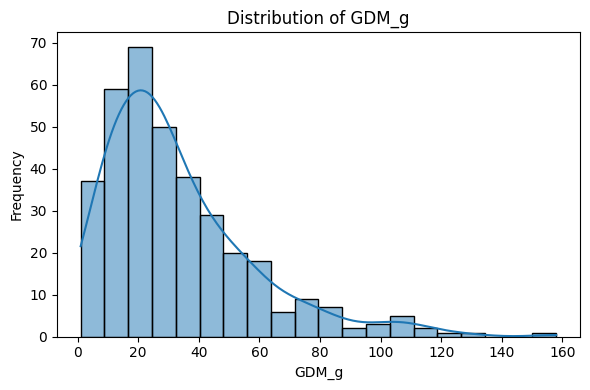

In [7]:
# Columns to plot
columns_to_plot = [
    "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm",
    "Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"
]

# Create separate distribution plots
for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if col == "Species": plt.xticks(rotation = 90)
    if col != "Species":plt.tight_layout()
    plt.show()

In [9]:
train_df.to_csv("dataset/train_df.csv", index = False)
train_df

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,State_code,Species_code
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750,1,11
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000,0,3
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500,3,12
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376,1,10
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,ID975115267,train/ID975115267.jpg,2015/7/8,WA,Clover,0.73,3.0000,40.0300,0.0000,0.8000,40.8300,40.8300,3,0
353,ID978026131,train/ID978026131.jpg,2015/9/4,Tas,Clover,0.83,3.1667,24.6445,4.1948,12.0601,40.8994,36.7046,1,0
354,ID980538882,train/ID980538882.jpg,2015/2/24,NSW,Phalaris,0.69,29.0000,0.0000,1.1457,91.6543,92.8000,91.6543,0,5
355,ID980878870,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,32.3575,0.0000,2.0325,34.3900,34.3900,3,0
